In [ ]:
!pip install rebound

In [22]:
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.integrate import odeint
import rebound
import threading
import os

#Laskar paper: https://physics.ucf.edu/~britt/Geophysics/Readings/G15-Evolution%20of%20obliquity.pdf
#Quarles paper: https://ui.adsabs.harvard.edu/abs/2022MNRAS.509.2736Q/abstract
#Quarles paper: https://ui.adsabs.harvard.edu/abs/2020AsBio..20...73Q/abstract

lock = threading.Lock()
home = os.getcwd() + "/"
data_dir = home + "K62_orb/"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)


M_e = 3.0035e-6 #Earth mass in M_sun
R_e = 4.26354E-5 #Earth radius in AU
Mstar_K62 = 0.69
K62b = [0.0552802,0.07071068,0.883,278.13010,90.373788,74.589661,2.71*M_e] #(semimajor axis, ecc, inclination, omega, Omega, Mean Anomaly, mass in M_sun)
K62c = [0.0928576,0.08602325,0.560,54.462322,90.473841,327.80383578,0.128*M_e]
K62d = [0.1195013,0.09486833,0.300,288.43494,90.002197,243.09602,4.94*M_e]
K62e = [0.4263096,0.13000000,0.303,292.61986,90.303058,63.220181,4.05*M_e]
K62f = [0.7176171,0.09433981,0.488,57.994616,90.478155,176.54639,3.57*M_e]

R_p = [1.31*R_e,0.54*R_e,1.95*R_e,1.61*R_e,1.41*R_e]

#P_K62b = np.sqrt(K62b[0]**3/Mstar_K62)*365.25
P_K62b = 5.714932
print(P_K62b*0.05)
P_K62f = np.sqrt(K62f[0]**3/Mstar_K62)

tscale = 1e5*365.25 #100,000 years for integration time
out_int = np.round(P_K62f*365.25,3)
days = np.arange(0, tscale+out_int, out_int)

pl_param = [K62b,K62c,K62d,K62e,K62f]
N_bodies = len(pl_param) + 1
for i in range(0,len(pl_param)):
    temp = pl_param[i]
    temp[2:6] = np.radians(temp[2:6])
    pl_param[i] = temp


def write2file(f_str,head,output_fldr,fn):
    lock.acquire() # thread blocks at this line until it can obtain lock
    if head == "head":
        f = open(output_fldr+fn,'w')
    else:
        f = open(output_fldr+fn,'a')
    f.write(f_str)
    f.close()
    lock.release()

def X2eps(x):
    return np.degrees(np.arccos(x))

def unfold_2pi(t,x):
    x_unfold = np.zeros(len(t))
    NN = 0
    for j in range(0,len(t)-1):
        diff = x[j+1] - x[j]
        if diff > 1.:
            NN -= 1
        if diff < -np.pi:
            NN += 1
        x_unfold[j+1] = x[j+1] + 2.*NN*np.pi
    return x_unfold

def deriv(y,t,alphat,ecct,CAt,CBt,CCt):
    Xt, psit = y
    if np.abs(Xt) < 1:
        term = Xt/np.sqrt(1.-Xt**2)
        root = np.sqrt(1.-Xt**2)
    else:
        term = -1.
        root = 0.
        
    dHdpsi = root*(CAt*np.cos(psit) - CBt*np.sin(psit))
    dHdX = alphat*Xt/(1.-ecct**2)**1.5-term*(CAt*np.sin(psit)+CBt*np.cos(psit)) - 2.*CCt
    return [-dHdpsi,dHdX]

def run_obl(time_arr,semi_t,ecc_t,inc_t,argP_t,RA_t,eps,alpha,dest):
    # initial obliquity = eps
    # alpha = precession constant
    #semi_t,ecc_t,inc_t,argP_t,RA_t are arrays from run_sim()
    #time_arr = np.copy(days)/365.25

    inc = np.radians(inc_t)
    RA = np.radians(RA_t)
    RA_cont = unfold_2pi(time_arr,RA)

    q = np.sin(inc/2.)*np.cos(RA)
    p = np.sin(inc/2.)*np.sin(RA)

    qt = UnivariateSpline(time_arr, q, s=0)
    pt = UnivariateSpline(time_arr, p, s=0)

    pdot = pt.derivative()(time_arr)
    qdot = qt.derivative()(time_arr)

    CC = qt(time_arr)*pdot-pt(time_arr)*qdot
    CA = 2./np.sqrt(1.-pt(time_arr)**2-qt(time_arr)**2)*(qdot + pt(time_arr)*CC)
    CB = 2./np.sqrt(1.-pt(time_arr)**2-qt(time_arr)**2)*(pdot - qt(time_arr)*CC)
    
    
    Chi,psi = np.zeros(len(time_arr)),np.zeros(len(time_arr))
    i_spin = np.zeros(len(time_arr))
    if eps == 0:
        eps = 1e-6
    Chi[0] = np.cos(np.radians(eps))
    psi[0] = np.radians(90.478155) #RA_f so that psi - RA_f = Delta Omega = 0
    
    write2file("%1.6e %1.6f %1.6f %3.5f %3.5f %3.5f %3.5f\n" % (0,semi_t[0],ecc_t[0],argP_t[0],RA_t[0],eps,np.degrees(psi[0])),'head',dest,'obl_data.txt')
    tstep = time_arr[1]/10.
    
    for t in range(1,len(time_arr)):
        delta_t = np.arange(time_arr[t-1],time_arr[t]+tstep,tstep)
        y0 = [Chi[t-1],psi[t-1]]
        alp = alpha/3600.*np.pi/180.
        temp = odeint(deriv,y0,delta_t,args=(alp,ecc_t[t-1],CA[t-1],CB[t-1],CC[t-1]),atol=1e-10,rtol=1e-10)
        Chi[t],psi[t] = temp[-1,0],temp[-1,1]
        if not np.isfinite(Chi[t]):
            Chi[t] = 1.

        ArgP = argP_t[t] % 360.
        LongP = RA_t[t] % 360.
        Obl = X2eps(Chi[t])
        PrecA = np.degrees(psi[t]) % 360.
        write2file("%1.6e %1.6f %1.6f %3.5f %3.5f %3.5f %3.5f\n" % (time_arr[t],semi_t[t],ecc_t[t],ArgP,LongP,Obl,PrecA),'foot',dest,'obl_data.txt')

    return

def run_sim():
    sim = rebound.Simulation()
    sim.integrator = "mercurius"
    sim.units = ('days', 'AU', 'Msun')
    sim.dt = np.round(0.03*P_K62b,4)
    sim.ri_whfast.corrector = 5 # needed because the default whfast is only 2nd order
    #sim.ri_whfast.safe_mode = 0
    sim.ri_ias15.min_dt = 1e-4*sim.dt

    sim.add(m=Mstar_K62)
    #Don't do bottom sim.add, bc of below for loop
    #Take lenght of pl_param (pl_param) and retrieves information of each particle 
    for i in range(0,len(pl_param)):
        temp = pl_param[i]
        sim.add(m=temp[-1],a=temp[0],e=temp[1],inc=temp[2],omega=temp[3],Omega=temp[4],M=temp[5],r=R_p[i])
    sim.move_to_com()

    ps = sim.particles

    fname = "Orb_data.txt"
    write2file("",'head',data_dir,fname) ##time,flux,ecc,varpi,inc,Omg\n
    K62f_idx = 5
    for d in range(0,len(days)):
        sim.integrate(days[d],exact_finish_time=0)
        #sim.ri_whfast.recalculate_coordinates_this_timestep = 1
        #sim.integrator_synchronize()
        ecc_t = ps[K62f_idx].e
        omg_t = np.degrees(ps[K62f_idx].omega) % 360.
        inc_t = np.degrees(ps[K62f_idx].inc)
        RA_t = np.degrees(ps[K62f_idx].Omega) % 360.
        MA_t = np.degrees(ps[K62f_idx].M) % 360.

        if np.abs(ps[K62f_idx].a) > 0.75:
            return

        out_stg = "%1.6e %1.6f %1.6f %2.3f %2.3f %2.3f %2.3f\n" % (days[d]/365.25,ps[K62f_idx].a,ecc_t,inc_t,omg_t,RA_t,MA_t)
        write2file(out_stg,'foot',data_dir,fname)
        

    return 

run_sim()
time,semi_t,ecc_t,inc_t,argP_t,RA_t,MA_t = np.genfromtxt("K62_orb/Orb_data.txt",unpack=True)

G = 4*np.pi**2
Msun = 0.69
semi = 0.7176171
Ed = 0.0008267/3.29610800e-01 #J_2/Cbar
hr = 23. + 56./60. + 4./3600. #rotation period in hours
w0 = 2.*np.pi/hr*24.*365.2422 #rotation frequency in rad/yr
alpha = 1.5*G*Msun/semi**3/w0*Ed
alpha *= 180./np.pi*3600.
print(alpha)

eps = 23.5 #initial obliquity in degrees
#alpha = 50.38312 # in arcsec/yr using 12 hr rotation
dest = data_dir
run_obl(time,semi_t,ecc_t,inc_t,argP_t,RA_t,eps,alpha,dest)


0.2857466
24.856769121859372


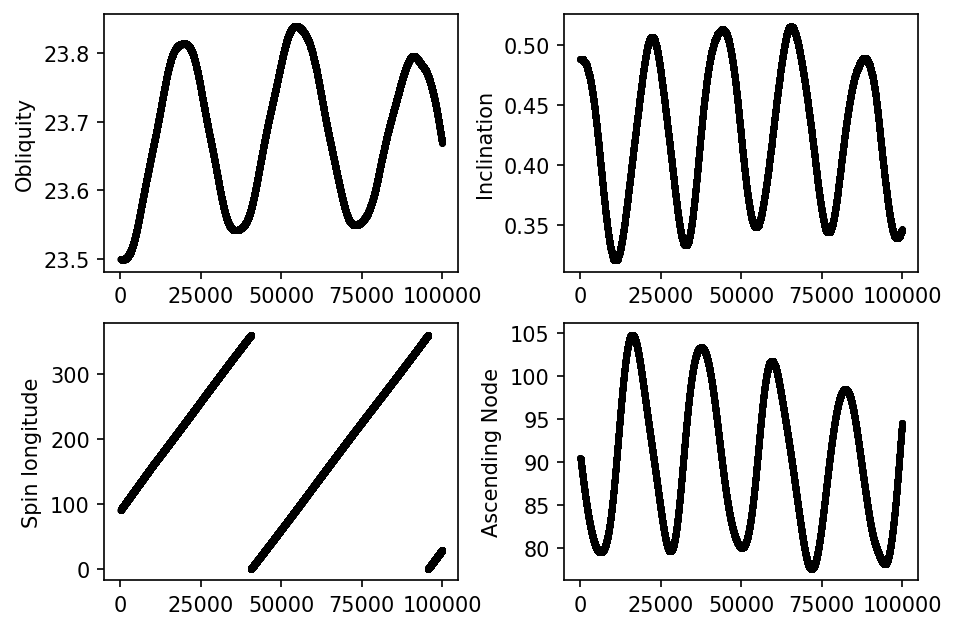

In [23]:
import matplotlib.pyplot as plt 
import numpy as np

time_o, inc, RA = np.genfromtxt("K62_orb/Orb_data.txt",usecols=(0,3,5),unpack=True)
time, eps, psi = np.genfromtxt("K62_orb/obl_data.txt",usecols=(0,5,6),unpack=True)

fig = plt.figure(figsize=(7,5),dpi=150)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(time[1:],eps[1:],'k.',ms=4)
ax3.plot(time[1:],psi[1:],'k.',ms=4)
ax2.plot(time_o[1:],inc[1:],'k.',ms=4)
ax4.plot(time_o[1:],RA[1:],'k.',ms=4)

ax1.set_ylabel("Obliquity")
ax2.set_ylabel("Inclination")
ax3.set_ylabel("Spin longitude")
ax4.set_ylabel("Ascending Node")

fig.subplots_adjust(wspace=0.3);